In [10]:
%%capture
!pip install statsforecast
!pip install mlforecast
!pip install utilsforecast
!pip install tsfeatures
!pip install squarify
!pip install neuralforecast
!pip install utilsforecast

!pip install neuralforecast datasetsforecast

In [12]:
%%capture
#needed to fix torch version issues
!pip uninstall -y torch torchvision
!pip install torch torchvision

In [ ]:
### Restart Kernel/Session at this point but do not run pip install again

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from prophet import Prophet
import os


import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    DIR = '/content/drive/MyDrive/AIM/Timeseries/FinalProject'
else:
    DIR = '.'

plt.style.use("ggplot")

plt.rcParams.update({
    "figure.figsize": (10, 4),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})

pd.set_option("display.precision", 3)
np.set_printoptions(suppress=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
### Consolidate Import and Export data
DAT_Export = pd.read_csv(f'{DIR}/data/SPGlobal_Exports_clean.csv',
                         parse_dates=['ds'])
DAT_Export.dropna(axis=0, inplace=True)
DAT_Export.columns = [f'{x}_export' if x != 'ds' else x for x in DAT_Export.columns]
DAT_Export = DAT_Export.melt(id_vars=['ds'], var_name='unique_id', value_name='y', ignore_index=True)


DAT_Import = pd.read_csv(f'{DIR}/data/SPGlobal_Imports_clean.csv', parse_dates=['ds'])
DAT_Import.dropna(axis=0, inplace=True)
DAT_Import.columns = [f'{x}_import' if x != 'ds' else x for x in DAT_Import.columns]
DAT_Import = DAT_Import.melt(id_vars=['ds'], var_name='unique_id', value_name='y', ignore_index=True)

DAT = pd.concat([DAT_Export, DAT_Import], axis=0)
DAT[DAT.ds > '2022-12-01'].reset_index(drop=True).to_csv(f'{DIR}/TEST.csv')
DAT[DAT.ds <= '2022-12-01'].reset_index(drop=True).to_csv(f'{DIR}/TRAIN.csv')

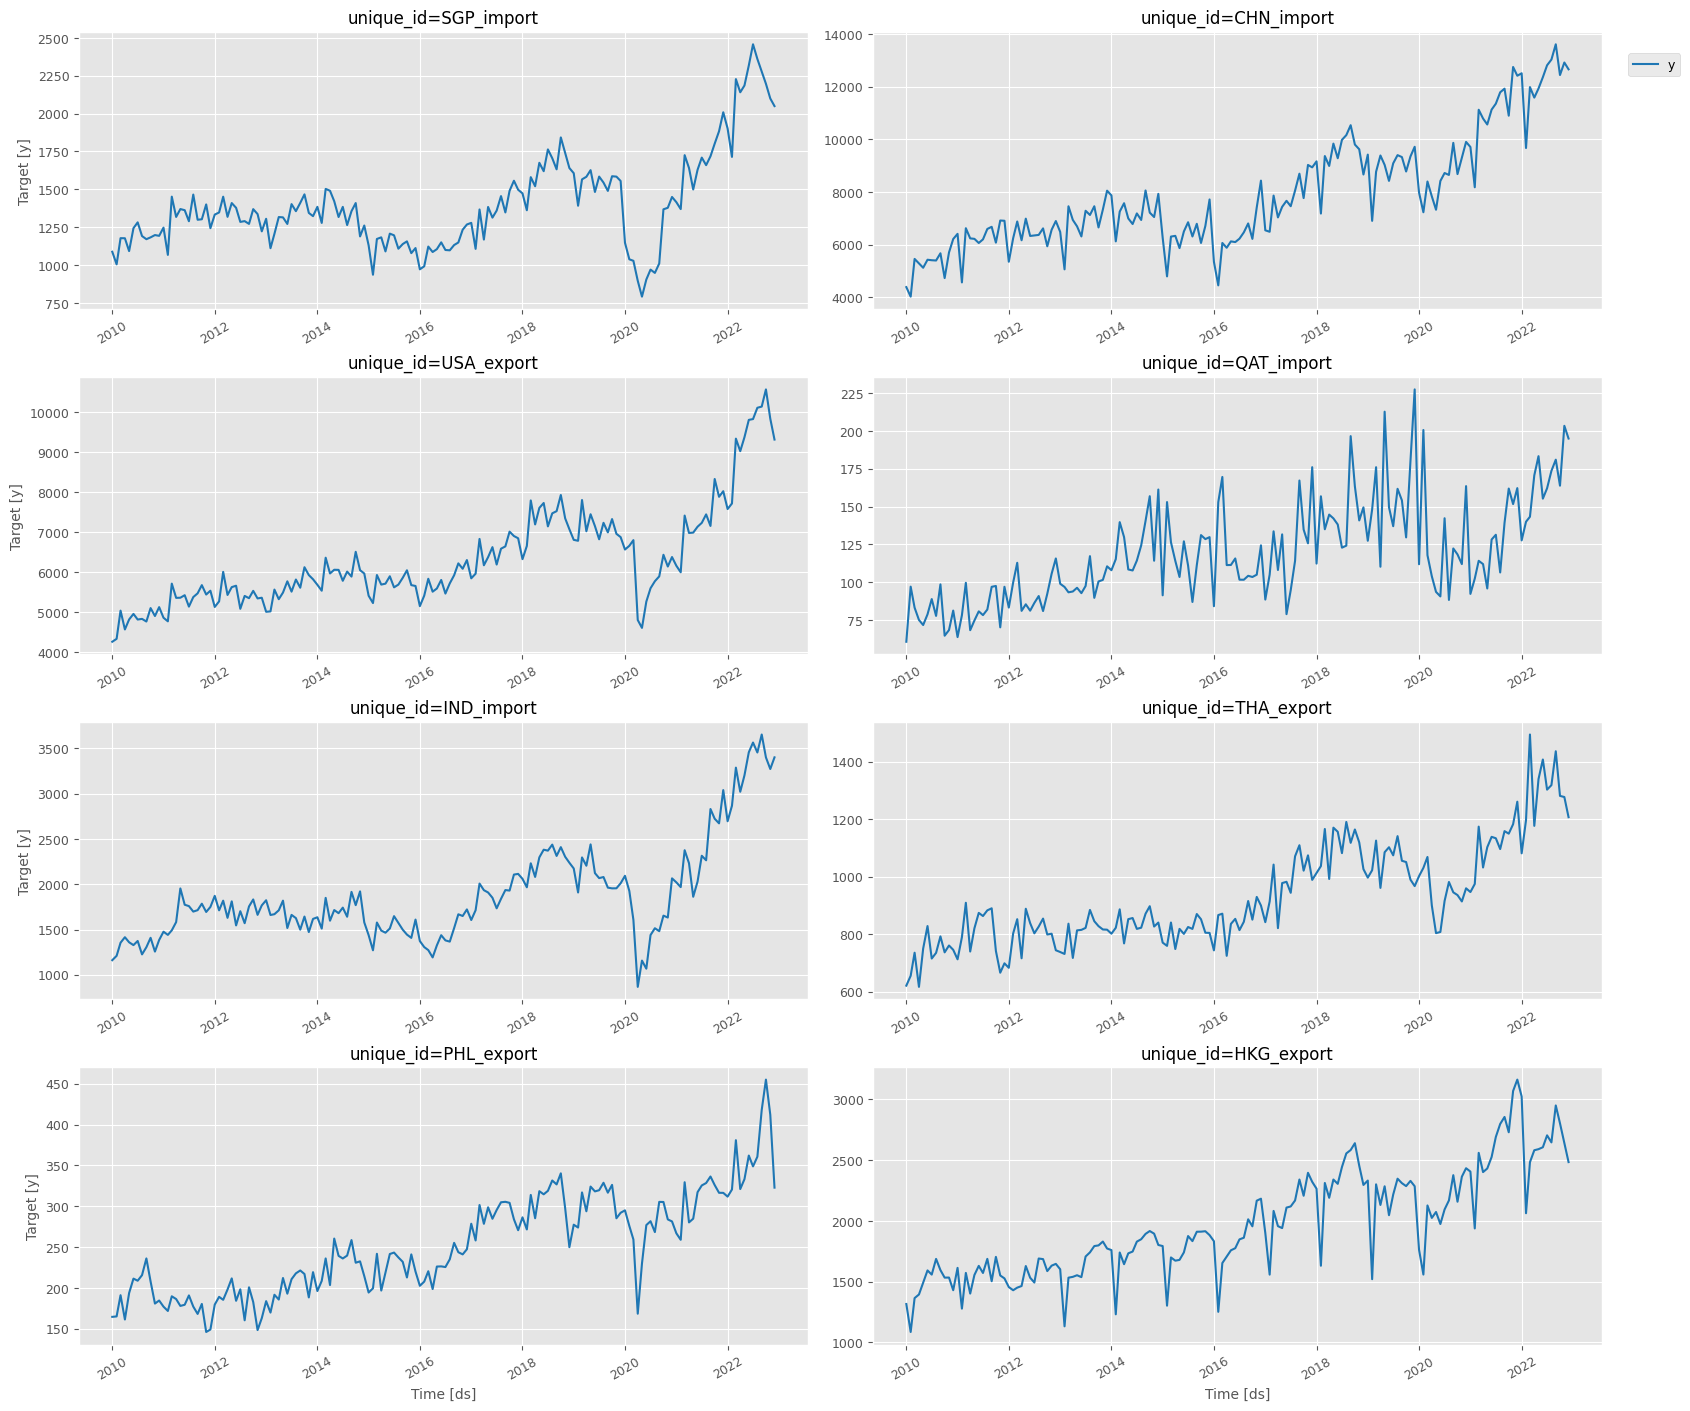

In [30]:
DAT_TRAIN = pd.read_csv(f'{DIR}/TRAIN.csv', parse_dates=['ds'],index_col=0)
DAT_TEST = pd.read_csv(f'{DIR}/TEST.csv', parse_dates=['ds'],index_col=0)


from utilsforecast.plotting import plot_series

custom_colors = ["black", "tab:blue"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
plot_series(DAT_TRAIN)


### (a) Baseline DeepAR (Vanilla model)

In [31]:
from neuralforecast import NeuralForecast
from neuralforecast.models import DeepAR #TFT, NBEATS, TimeGPT
from neuralforecast.losses.pytorch import DistributionLoss
import torch
torch.set_float32_matmul_precision('medium')


h = len(DAT_TEST.ds.unique())

models = [DeepAR(h=h,
                 input_size=2*h, #when predicting h, lookback 2*h
                 max_steps=2000,
                 scaler_type='robust',
                 trajectory_samples=200,
                 loss=DistributionLoss(distribution='StudentT', level=[80, 95]),
                 lstm_n_layers=2, #By default this is 1
                 lstm_hidden_size=64,
                 decoder_hidden_layers=2, #MLP layers, we force it. Be default = 0, linear layer
                 decoder_hidden_size=64,
                 ),
          ]

nf = NeuralForecast(models=models, freq='MS')
nf.fit(df=DAT_TRAIN)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | valid_loss   | MAE              | 0      | train
2 | padder_train | ConstantPad1d    | 0      | train
3 | scaler       | TemporalNorm     | 0      | train
4 | hist_encoder | LSTM             | 50.4 K | train
5 | decoder      | Decoder          | 4.4 K  | train
----------------------------------------------------------
54.8 K    Trainable params
5         Non-trainable params
54.8 K    Total params
0.2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.


In [32]:
df_f = nf.predict()
df_f = pd.merge(DAT_TEST, df_f, on=['ds', 'unique_id']) # append ground truth "y"

df_f

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

,ds,unique_id,y,DeepAR,DeepAR-median,DeepAR-lo-95,DeepAR-lo-80,DeepAR-hi-80,DeepAR-hi-95
0,2023-01-01,AUS_export,1844.198,2126.177,2108.686,1767.635,1856.675,2331.488,2460.634
1,2023-02-01,AUS_export,1682.179,2213.510,2203.377,1857.728,1984.419,2403.515,2525.747
2,2023-03-01,AUS_export,1897.200,2244.268,2237.305,1899.743,2018.563,2460.215,2586.309
3,2023-04-01,AUS_export,1652.244,2223.577,2194.659,1877.759,1992.126,2382.916,2476.938
4,2023-05-01,AUS_export,1782.240,2178.553,2176.098,1929.506,2019.857,2379.081,2450.757
...,...,...,...,...,...,...,...,...,...
967,2024-11-01,VNM_import,1799.830,1184.322,1187.526,1059.494,1114.488,1264.206,1350.261
968,2024-12-01,VNM_import,1911.778,1171.132,1172.020,1069.630,1108.938,1244.889,1287.214
969,2025-01-01,VNM_import,1652.929,1154.336,1154.898,1039.180,1081.492,1215.114,1258.867
970,2025-02-01,VNM_import,1763.304,1128.503,1134.572,958.029,1050.867,1212.689,1263.310


In [33]:
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mape as _mape, mase, rmsse

df_f = nf.predict() # Forecast!

def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include='number').columns] *= 100
    return df_mape

df_f = pd.merge(DAT_TEST, df_f, on=['ds', 'unique_id']) # append ground truth "y"

df_eval = evaluate(df_f, metrics=[mae, rmse, mape, partial(mase, seasonality=12), partial(rmsse, seasonality=12)], train_df=DAT_TRAIN) # mase uses snaive as scaler
df_eval.pivot(index='unique_id', columns='metric', values='DeepAR')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

metric,mae,mape,mase,rmse,rmsse
unique_id,,,,,
AUS_export,452.139,27.773,2.571,470.315,2.090
AUS_import,132.144,9.459,1.149,157.425,1.087
CHN_export,1598.462,9.793,1.393,2001.074,1.294
CHN_import,1013.511,8.272,0.994,1198.103,0.934
HKG_export,421.762,15.182,2.355,496.435,2.026
HKG_import,391.940,12.925,1.899,473.547,1.778
IDN_export,142.595,12.002,1.162,173.074,1.020
IDN_import,210.741,19.027,1.705,250.320,1.592
IND_export,210.270,10.460,1.059,240.358,0.873


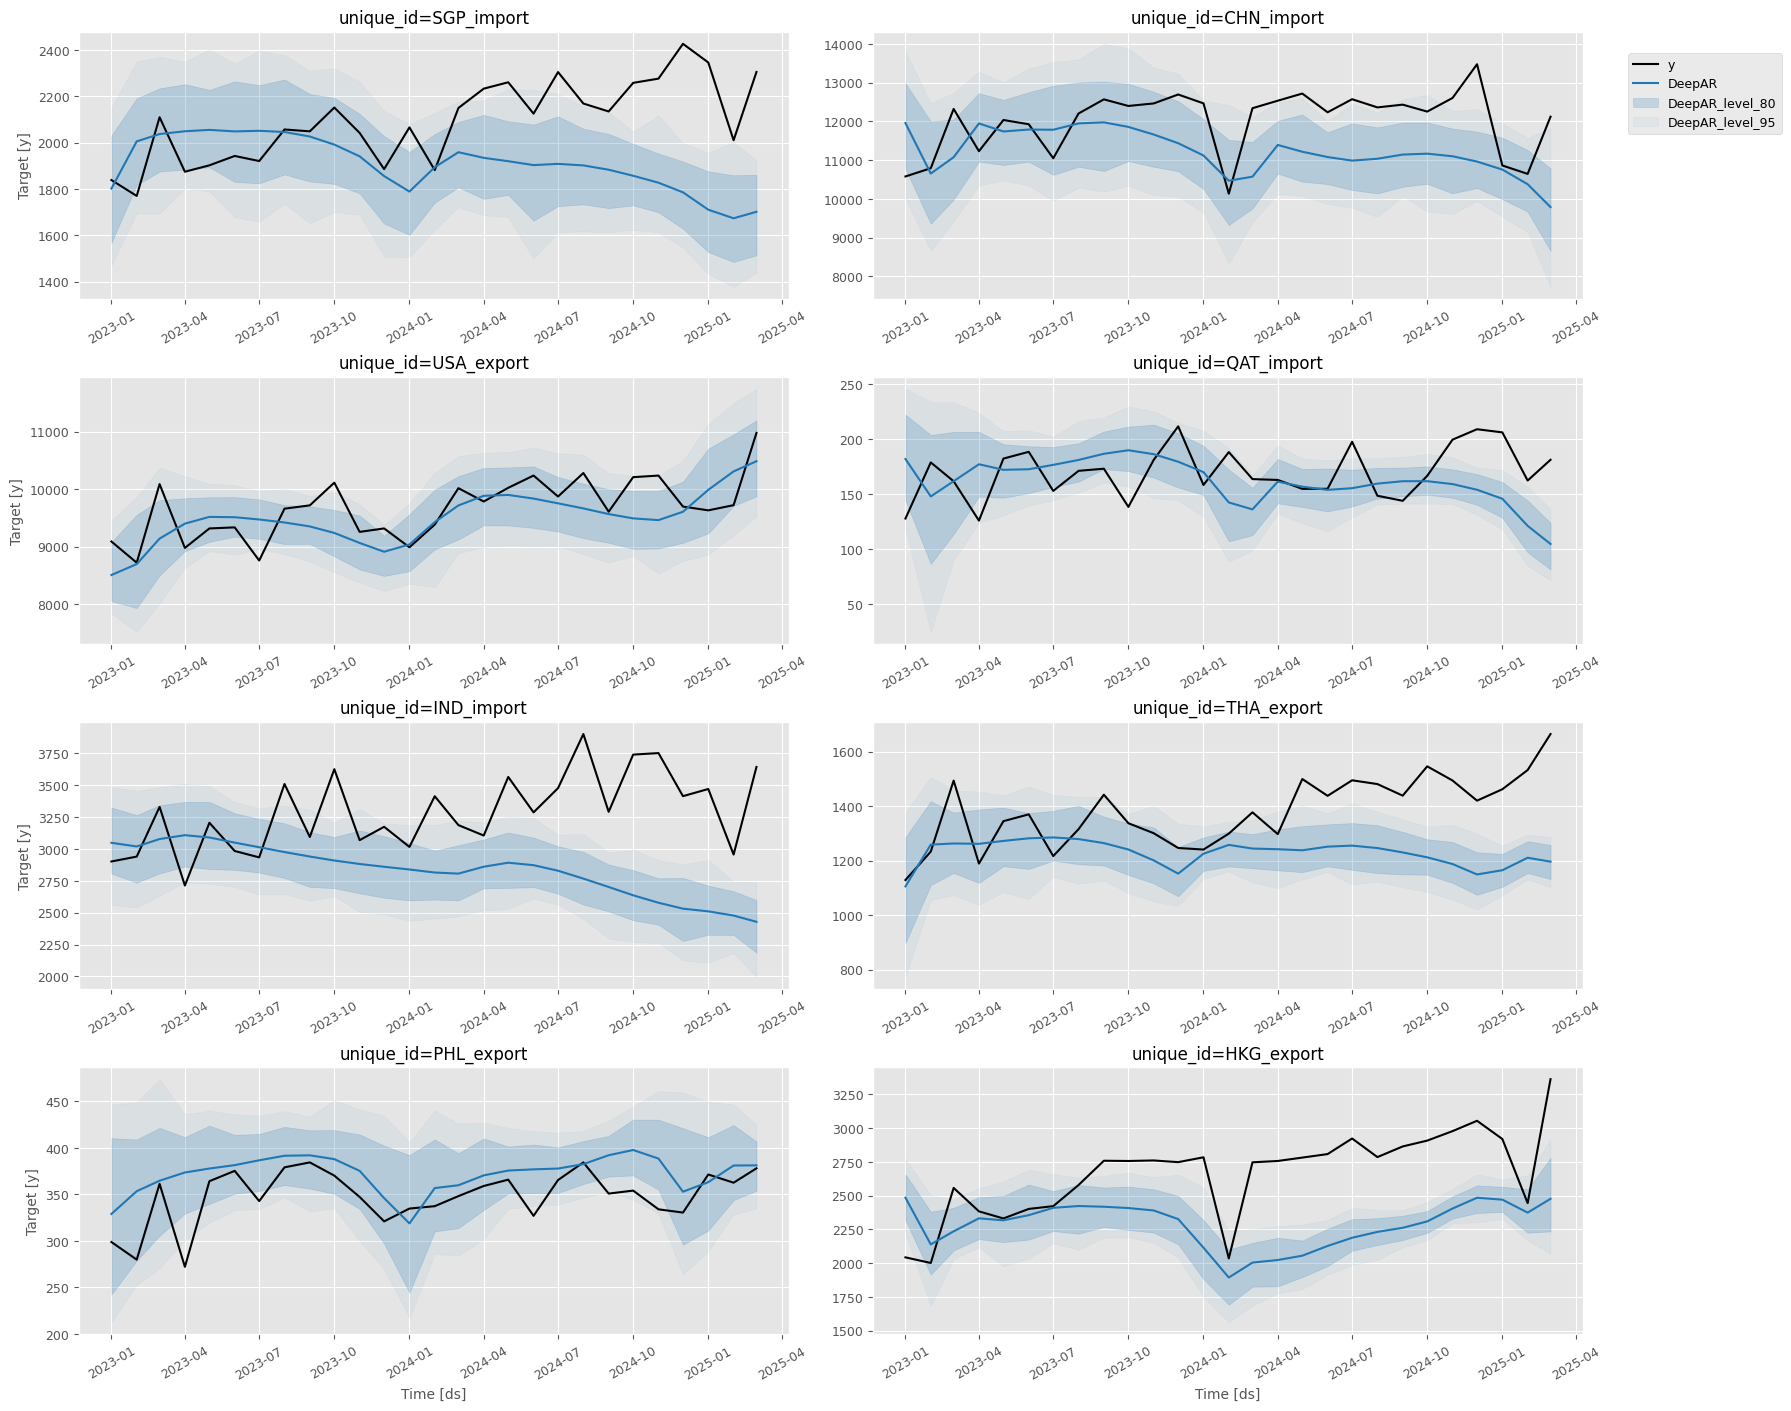

In [34]:
from utilsforecast.plotting import plot_series

custom_colors = ["black", "tab:blue"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
plot_series(DAT_TEST, df_f.drop(['DeepAR-median', 'y'], axis=1), level=[80, 95])

In [55]:
### (b) features DeepAR
from functools import partial
from utilsforecast.feature_engineering import fourier, time_features, pipeline

features = [
    partial(fourier, season_length = 3, k=1),
    partial(time_features, features = ['quarter'])
]



df = DAT_TRAIN.pivot(index='ds', columns='unique_id', values='y')
df.index = pd.to_datetime(df.index)


df_static = (pd.get_dummies(df.columns)
            .astype(int)
            .set_index(df.columns))



df_train, df_futr = pipeline(
    DAT_TRAIN,
    features = features,
    freq = 'MS',
    h=h
)

In [56]:
from torch.optim import AdamW

models = [DeepAR(h=h,
                 #input_size=2*h, #when predicting h, lookback 2*h
                 futr_exog_list = ['sin1_3','cos1_3'],
                 stat_exog_list = df_static.columns,
                 max_steps=2000,
                 scaler_type='robust',
                 trajectory_samples=200,
                 loss=DistributionLoss(distribution='StudentT', level=[80, 95]),
                 lstm_n_layers=2, #By default this is 1
                 lstm_hidden_size=64,
                 decoder_hidden_layers=2, #MLP layers, we force it. Be default = 0, linear layer
                 decoder_hidden_size=64,
                 optimizer = AdamW,
                 ),
          ]

nf = NeuralForecast(models=models, freq='MS')
nf.fit(df=df_train, static_df = df_static)

/usr/local/lib/python3.12/dist-packages/neuralforecast/common/_base_model.py:138: UserWarning: Input size too small. Automatically setting input size to 3 * horizon = 81
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | valid_loss   | MAE              | 0      | train
2 | padder_train | ConstantPad1d    | 0      | train
3 | scaler       | TemporalNorm     | 0      | train
4 | hist_encoder | LSTM             | 60.2 K | train
5 | decod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

metric,mae,mape,mase,rmse,rmsse
unique_id,,,,,
AUS_export,508.782,31.172,2.893,524.550,2.331
AUS_import,216.214,15.493,1.880,247.263,1.708
CHN_export,3053.001,17.790,2.660,3616.351,2.339
CHN_import,486.105,4.332,0.477,745.027,0.581
HKG_export,210.289,8.186,1.174,252.221,1.029
HKG_import,233.026,7.971,1.129,283.405,1.064
IDN_export,112.158,9.342,0.914,133.470,0.786
IDN_import,302.194,27.069,2.445,365.641,2.326
IND_export,449.667,21.029,2.265,535.996,1.947


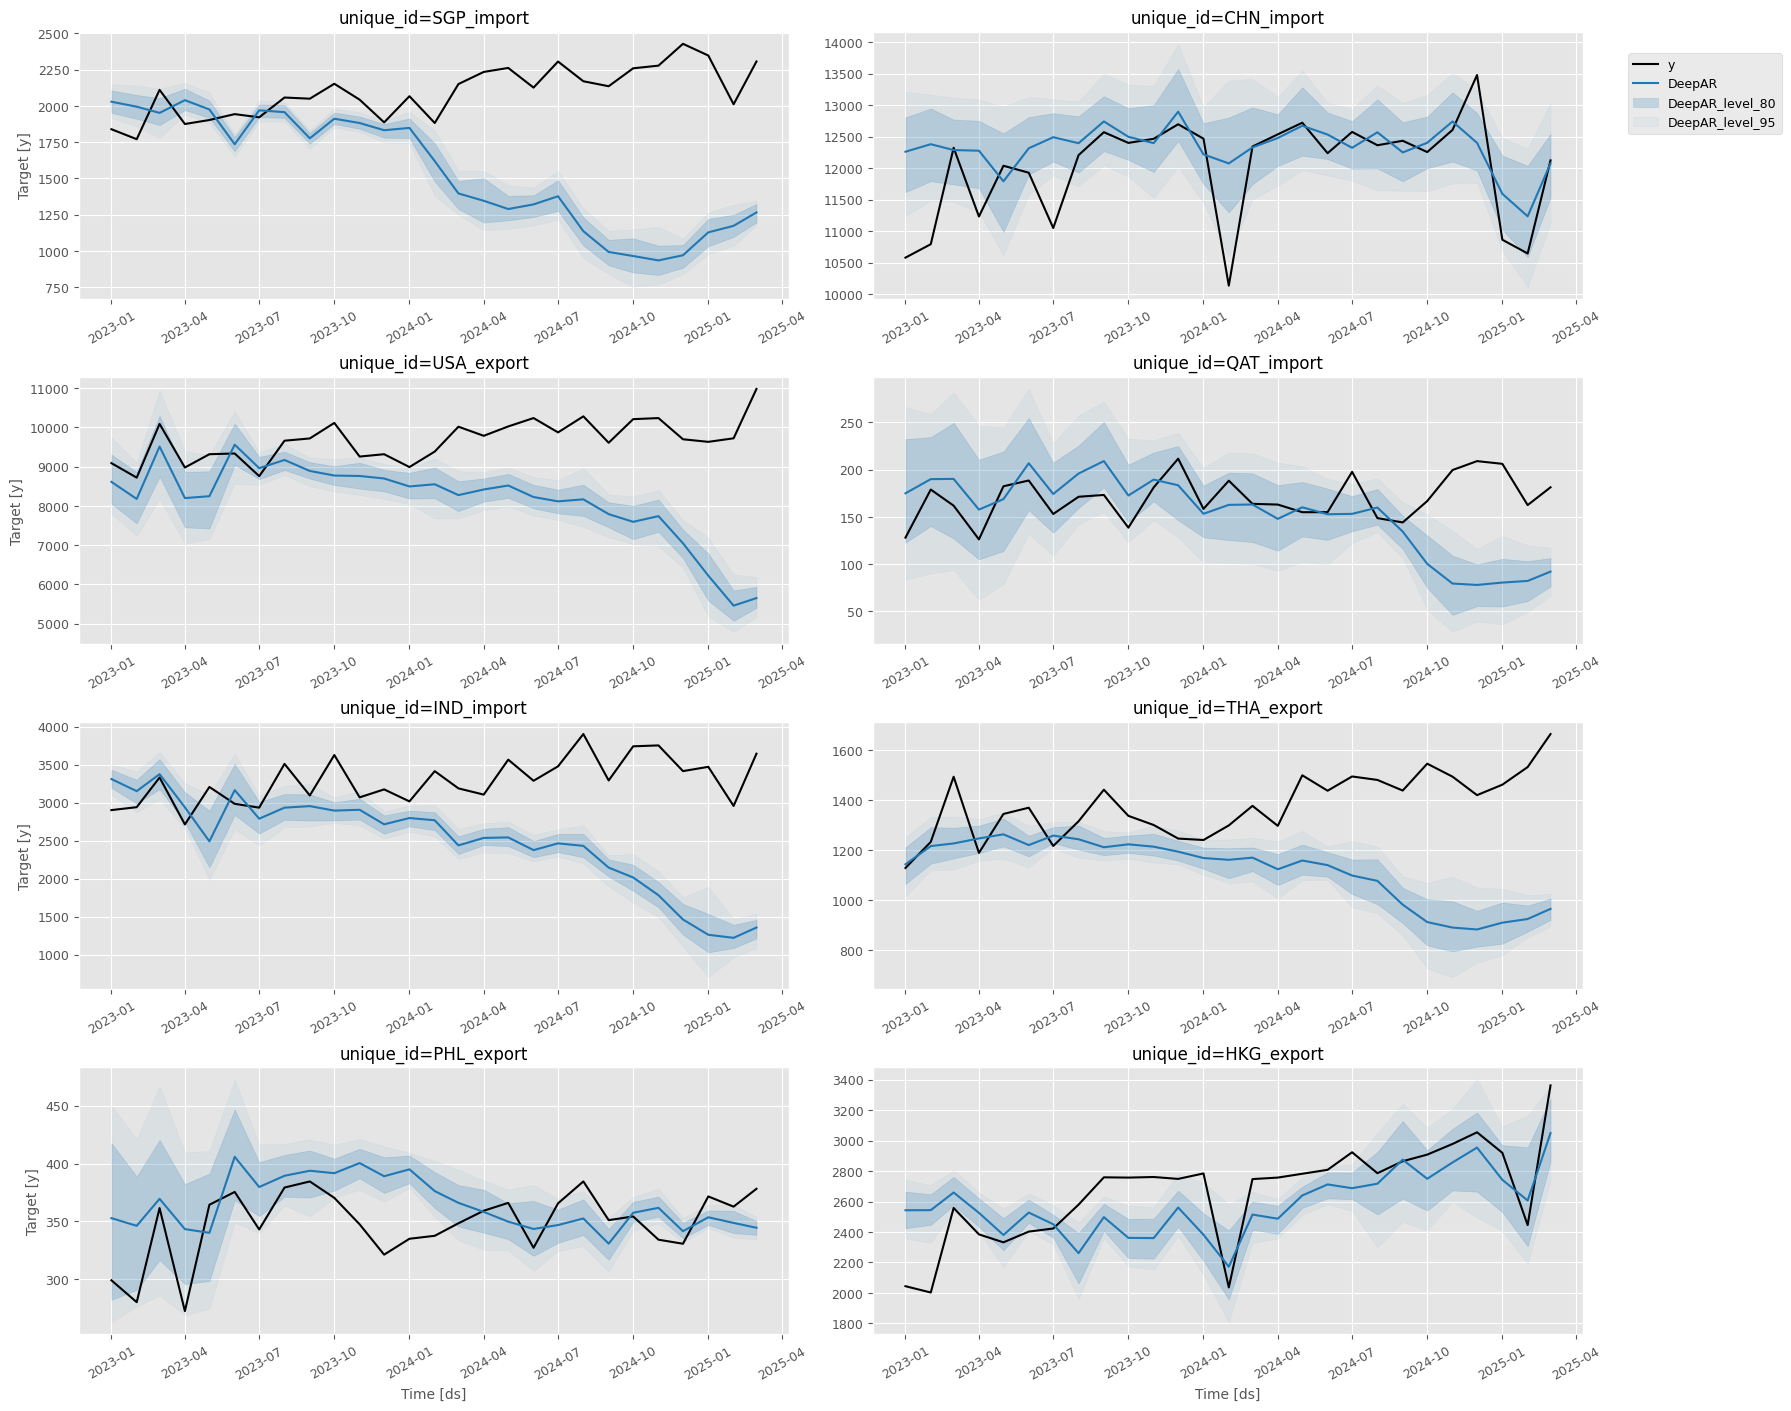

In [57]:
df_f = nf.predict(static_df = df_static, futr_df = df_futr) # Forecast!

df_f = pd.merge(DAT_TEST, df_f, on=['ds', 'unique_id']) # append ground truth "y"

df_eval = evaluate(df_f, metrics=[mae, rmse, mape, partial(mase, seasonality=12), partial(rmsse, seasonality=12)], train_df=DAT_TRAIN) # mase uses snaive as scaler
display(df_eval.pivot(index='unique_id', columns='metric', values='DeepAR'))

plot_series(DAT_TEST, df_f.drop(['DeepAR-median', 'y'], axis=1), level=[80, 95])

Research on calendar effects of exports/import activity

In [ ]:
### (c) STL + DeepAR


### (d) STL + features